# ElasticAST evaluated on AudioSet
All the evaluation logs can be observed below.

When doing it your self, please change the directory accordingly.

NOTE: AudioSet is a fixed-length dataset, and the experiments are used to measure the performance for **various resolution**.

Here we use the results from seed A, which also shows at https://sites.google.com/view/elasticast-interpseech24

## Create and load the model

In [1]:
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from tqdm import tqdm


from models import ElasticAST
import numpy as nps
from utilities import *

batch_size = 12
mel_bins = 128
audio_length = 1024
dataset = 'audioset'
dataset_mean=-4.414
dataset_std=4.905
Fshift = 10
window_size = 25
data_val = '/home/jfeng/FJ/ElasticAST/egs/audioset/data/datafiles/eval.json'
label_csv = '/home/jfeng/FJ/ElasticAST/egs/audioset/data/class_labels_indices.csv'
class_num = 527

model = ElasticAST(
    sample_size = (mel_bins,int(audio_length/1)),
    patch_size = 16,
    num_classes = class_num,
    dim = 768,
    depth = 12,
    heads = 12,
    dropout = 0,
    emb_dropout = 0,
    token_dropout_prob = 0,  # token dropout of 10% (keep 90% of tokens)
    channels=1,
)


model_load = "/home/jfeng/FJ/ElasticAST/pretrain_weights/ElasticAST_AudioSet.pth"


out_dict = {}
state_dict = torch.load(model_load,map_location=torch.device('cpu'))
for k, v in state_dict.items(): # Adjust the name of dict
    out_dict[k[7:]] = v
model.load_state_dict(out_dict, strict=True)

/home/jfeng/anaconda3/envs/flexiast2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

## Prepare for the datasets and evaluation pipelines.

In [2]:
import dataloader

quality_ratio = np.arange(1, 4.2, 0.2)
quality_acc = []

val_audio_conf = {'num_mel_bins': mel_bins, 'target_length': audio_length, 'freqm': 0, 'timem': 0, 'mixup': 0,
                'dataset': dataset, 'mode': 'evaluation', 'mean': dataset_mean, 'std': dataset_std, 'noise': False,
                'Fshift': Fshift,"window_size":window_size}

for q in quality_ratio:
    # keep q two decimal places
    q = round(q, 2)
    val_loader = torch.utils.data.DataLoader(
    dataloader.ElasticQuality_Dataset(data_val, label_csv=label_csv, audio_conf=val_audio_conf,quality_ratio=[q]),
    batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True,collate_fn=dataloader.list_collate)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
            if not isinstance(model, nn.DataParallel):
                model = nn.DataParallel(model)
            A_predictions = []
            A_targets = []
            with tqdm(val_loader) as vepoch:
                for data_items, labels in vepoch:
                    data_items, labels = data_items, labels
                    for i in range(len(data_items)):
                        data_items[i] = data_items[i].to(device)

                    # max_seq_len=2048
                    max_seq_len=int(1024/q)
                    outputs = model(data_items,group_samples=True,group_max_seq_len=max_seq_len)
                    outputs = torch.sigmoid(outputs)
                    predictions = outputs.to('cpu').detach()

                    A_predictions.append(predictions)
                    A_targets.append(labels)

                    labels = labels.to(device)

            outputs = torch.cat(A_predictions)
            labels = torch.cat(A_targets)
            stats = calculate_stats(outputs, labels)


    mAP = np.mean([stat['AP'] for stat in stats])
    acc = stats[0]['acc']
    print(f"Mel-spec resolution is compressed {q} times, mAP: {mAP}, acc: {acc}")
    quality_acc.append(mAP)

print(quality_acc)

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.414 and std 4.905 to normalize the input.
number of classes is 527
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1621/1621 [01:25<00:00, 19.07it/s]


Mel-spec resolution is compressed 1.0 times, mAP: 0.4204830992801962, acc: 0.46850089997428646
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.414 and std 4.905 to normalize the input.
number of classes is 527
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1621/1621 [01:21<00:00, 19.78it/s]


Mel-spec resolution is compressed 1.2 times, mAP: 0.4200342937891903, acc: 0.4670095140138853
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.414 and std 4.905 to normalize the input.
number of classes is 527
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1621/1621 [01:14<00:00, 21.83it/s]


Mel-spec resolution is compressed 1.4 times, mAP: 0.41923722569493915, acc: 0.4673695037284649
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.414 and std 4.905 to normalize the input.
number of classes is 527
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1621/1621 [01:09<00:00, 23.32it/s]


Mel-spec resolution is compressed 1.6 times, mAP: 0.4161738930529736, acc: 0.46608382617639493
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.414 and std 4.905 to normalize the input.
number of classes is 527
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1621/1621 [01:05<00:00, 24.93it/s]


Mel-spec resolution is compressed 1.8 times, mAP: 0.41476290311460934, acc: 0.4654667009514014
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.414 and std 4.905 to normalize the input.
number of classes is 527
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1621/1621 [01:01<00:00, 26.33it/s]


Mel-spec resolution is compressed 2.0 times, mAP: 0.41334498585215684, acc: 0.4675752121367961
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.414 and std 4.905 to normalize the input.
number of classes is 527
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1621/1621 [00:57<00:00, 28.09it/s]


Mel-spec resolution is compressed 2.2 times, mAP: 0.40850652543962596, acc: 0.46603239907431215
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.414 and std 4.905 to normalize the input.
number of classes is 527
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1621/1621 [00:54<00:00, 29.79it/s]


Mel-spec resolution is compressed 2.4 times, mAP: 0.40767443552856425, acc: 0.46294677294934433
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.414 and std 4.905 to normalize the input.
number of classes is 527
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1621/1621 [00:51<00:00, 31.74it/s]


Mel-spec resolution is compressed 2.6 times, mAP: 0.4055956871785525, acc: 0.46443815890974544
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.414 and std 4.905 to normalize the input.
number of classes is 527
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1621/1621 [00:49<00:00, 32.71it/s]


Mel-spec resolution is compressed 2.8 times, mAP: 0.4014891746022721, acc: 0.46454101311391105
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.414 and std 4.905 to normalize the input.
number of classes is 527
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1621/1621 [00:48<00:00, 33.16it/s]


Mel-spec resolution is compressed 3.0 times, mAP: 0.4000271564416957, acc: 0.46176394960143996
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.414 and std 4.905 to normalize the input.
number of classes is 527
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1621/1621 [00:48<00:00, 33.25it/s]


Mel-spec resolution is compressed 3.2 times, mAP: 0.3969780363151855, acc: 0.461249678580612
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.414 and std 4.905 to normalize the input.
number of classes is 527
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1621/1621 [00:47<00:00, 34.39it/s]


Mel-spec resolution is compressed 3.4 times, mAP: 0.3918144501005082, acc: 0.45975829262021084
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.414 and std 4.905 to normalize the input.
number of classes is 527
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1621/1621 [00:47<00:00, 34.23it/s]


Mel-spec resolution is compressed 3.6 times, mAP: 0.39005137282590713, acc: 0.45914116739521726
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.414 and std 4.905 to normalize the input.
number of classes is 527
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1621/1621 [00:46<00:00, 34.96it/s]


Mel-spec resolution is compressed 3.8 times, mAP: 0.38598379094485763, acc: 0.45811262535356134
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.414 and std 4.905 to normalize the input.
number of classes is 527
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1621/1621 [00:45<00:00, 35.27it/s]


Mel-spec resolution is compressed 4.0 times, mAP: 0.3865883194609716, acc: 0.4581640524556441
[0.4204830992801962, 0.4200342937891903, 0.41923722569493915, 0.4161738930529736, 0.41476290311460934, 0.41334498585215684, 0.40850652543962596, 0.40767443552856425, 0.4055956871785525, 0.4014891746022721, 0.4000271564416957, 0.3969780363151855, 0.3918144501005082, 0.39005137282590713, 0.38598379094485763, 0.3865883194609716]


In [3]:
# What we obtained above is:
elastic_ast = [0.4204830992801962, 0.4200342937891903, 0.41923722569493915, 0.4161738930529736, 0.41476290311460934, 0.41334498585215684, 0.40850652543962596, 0.40767443552856425, 0.4055956871785525, 0.4014891746022721, 0.4000271564416957, 0.3969780363151855, 0.3918144501005082, 0.39005137282590713, 0.38598379094485763, 0.3865883194609716]

# Belows are the baseline results from none-compressed to 4.0 times compressed
baseline = [0.4294617775, 0.4162106789, 0.3963454136, 0.3698440543, 0.3454094248, 0.3204185072, 0.2954269518, 0.2698783128, 0.2513895927, 0.2295260227, 0.2135688621, 0.1956920208, 0.1809978982, 0.1663811215, 0.151214804, 0.146131303]
Fshfit20 = [0.3638200337, 0.3914474495, 0.406512784, 0.4117797019, 0.4128535667, 0.4134793013, 0.4072293217, 0.3981825421, 0.390067204, 0.3788337435, 0.3712013325, 0.3573317335, 0.3451375867, 0.3320326804, 0.3170868545, 0.3117024945]
Fshift30 = [0.2918603365, 0.3308459238, 0.351905946, 0.3681601669, 0.378947318, 0.3850965782, 0.3872893068, 0.3924274608, 0.3945658966, 0.393116525, 0.3955847334, 0.388482243, 0.3838859558, 0.379222377, 0.3726121138, 0.3695659573]
Fshift40 = [0.2323779039, 0.2713271771, 0.2980943315, 0.3188796375, 0.3359972997, 0.3467561276, 0.3548366116, 0.3624687912, 0.3677172653, 0.3711789596, 0.377853095, 0.3777529031, 0.3760302884, 0.3747662761, 0.3731927889, 0.3787472746]

# Visualization

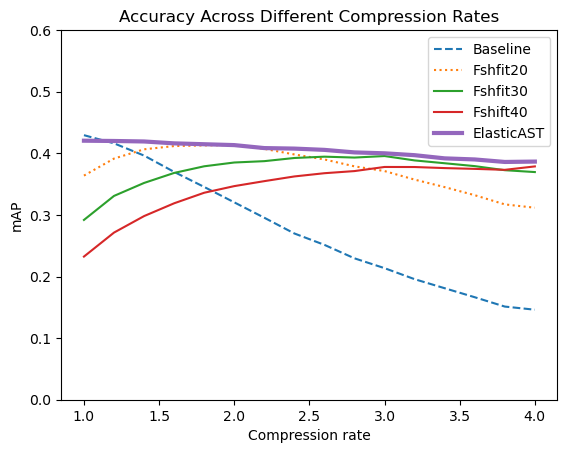

In [5]:
# draw the plot
import matplotlib.pyplot as plt

plt.plot(quality_ratio, baseline, label="Baseline",linestyle='--')
plt.plot(quality_ratio, Fshfit20, label="Fshfit20",linestyle=':')
plt.plot(quality_ratio, Fshift30, label="Fshfit30",linestyle='-')
plt.plot(quality_ratio, Fshift40, label="Fshift40",linestyle='-')
plt.plot(quality_ratio, elastic_ast, label="ElasticAST",linewidth=3)

plt.legend()
plt.xlabel("Compression rate")
plt.ylabel("mAP")
plt.title("Accuracy Across Different Compression Rates")
# show grid

# set y-axis range
plt.ylim(0.0, 0.6)

plt.show()